In [ ]:
# default_exp data.las

# Las

> Basic functionalities to work and process point cloud (LAS/LAZ) files

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import product 
from scipy.stats import skew, kurtosis, entropy

In [ ]:
#hide
from pathlib import Path
import os
import random
import re
from fastcore.test import *

# Opening and plotting point clouds

In [ ]:
data_path = Path('data/')
example = '914153.las'

plot_x = 365188.3 # measured x-coordinate of plot center 
plot_y = 6943847.83 # measured y-coordinate of plot center

`laspy` is used for opening las-files.

In [ ]:
data = laspy.file.File(data_path/example, mode='r')

Point clouds have the following features for each point.

In [ ]:
for spec in data.point_format: print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time


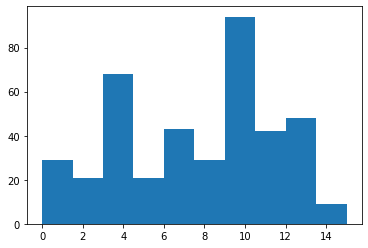

In [ ]:
intensities = np.array([p[0][3] for p in data.points])
plt.hist(intensities, bins='auto')
plt.show()

In [ ]:
# export
def plot_point_cloud(lasfile:laspy.file.File, **kwargs) -> plt.Axes:
    "Return 3d-projection of point cloud"
    points = lasfile.points.copy()
    las_scaleX = lasfile.header.scale[0]
    las_scaleY = lasfile.header.scale[1]
    las_scaleZ = lasfile.header.scale[2]
    las_offsetX = lasfile.header.offset[0]
    las_offsetY = lasfile.header.offset[1]
    las_offsetZ = lasfile.header.offset[2]

    p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
    p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
    p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)

    fig = plt.figure(figsize=(10,10), **kwargs)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(p_X, p_Y, p_Z, c='r', marker='o')
    return ax

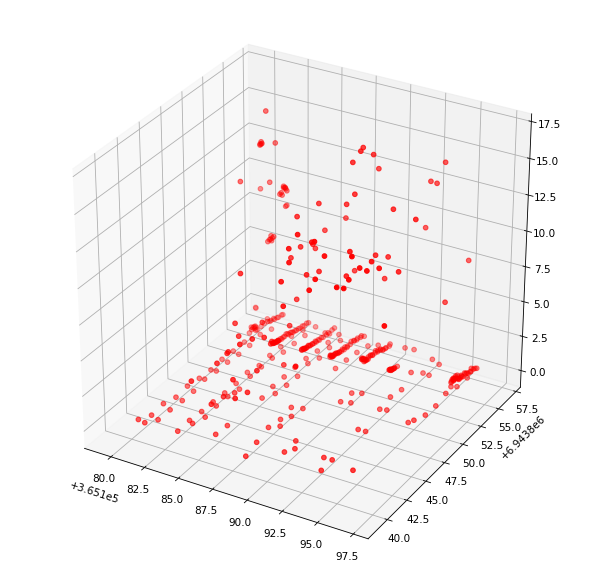

In [ ]:
plot_point_cloud(data, dpi=75)
plt.show()

In [ ]:
# export
def plot_2d_views(lasfile:laspy.file.File)-> plt.Axes:
    "Return X-Y, X-Z and Y-Z -views from lasfile"
    points = lasfile.points.copy()
    las_scaleX = lasfile.header.scale[0]
    las_scaleY = lasfile.header.scale[1]
    las_scaleZ = lasfile.header.scale[2]
    las_offsetX = lasfile.header.offset[0]
    las_offsetY = lasfile.header.offset[1]
    las_offsetZ = lasfile.header.offset[2]

    p_X = np.array((points['point']['X'] * las_scaleX) + las_offsetX)
    p_Y = np.array((points['point']['Y'] * las_scaleY) + las_offsetY)
    p_Z = np.array((points['point']['Z'] * las_scaleZ) + las_offsetZ)
    fig, axs = plt.subplots(1,3, figsize=(13,4))
    axs[0].scatter(p_X, p_Y)
    axs[0].grid()
    axs[0].set_title('X=lon, Y=lat')
    axs[1].scatter(p_X, p_Z)
    axs[1].grid()
    axs[1].set_title('X=lon, Y=height')
    axs[2].scatter(p_Y, p_Z)
    axs[2].grid()
    axs[2].set_title('X=lat, Y=height')
    return axs

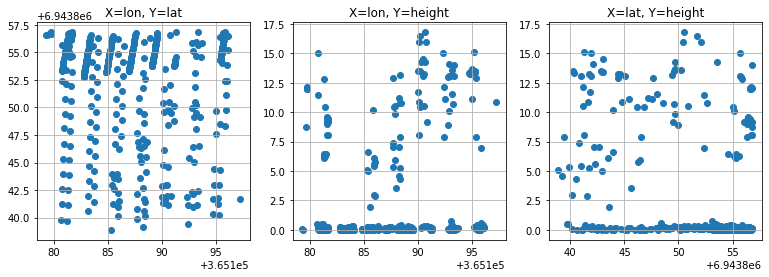

In [ ]:
plot_2d_views(data)
plt.show()

There are other views that can be used, like those presented in [Hamraz(2019)](https://www.sciencedirect.com/science/article/pii/S0924271619302485). 

First, the DSM x 4 -format, where the point cloud is pinned to a square horizontal grid, and for each pixel the following values are recorded:
1. Elevation above ground of the highest leaf-on point
2. Normalized intensity of the highest leaf-on point
3. Elevation above ground of the highest leaf-off point 
4. Normalized intensity of the highest leaf-off point

Our data does not contain enough information for this, unfortunately.

# LiDAR point clouds to tabular format

Opening and calculating field plot -specific features from a point cloud file. 

In [ ]:
#export

def las_to_df(fn:str) -> pd.DataFrame:
    """Open .las-file and return it as dataframe with columns [x, y, z, num_returns, intensity].
    Also convert point cloud to photogrammetric, meaning only one z-coordinate in each x-y -pair"""
    lasfile = laspy.file.File(fn, mode='r')
    lidar_df = pd.DataFrame(columns=['x', 'y', 'z', 'num_returns', 'return_num', 'scan_angle_rank', 'intensity'],
                            data=np.dstack((lasfile.x, 
                                            lasfile.y, 
                                            lasfile.z, 
                                            lasfile.num_returns, 
                                            lasfile.return_num,
                                            lasfile.scan_angle_rank,
                                            lasfile.intensity))[0])
    # Make sure we only have one value for each x,y -point (photogrammetric point cloud)
    #lidar_df = lidar_df.drop_duplicates(['x','y'], keep='last')
    lasfile.close()
    return lidar_df

def mask_plot_from_lidar(lidar_df:pd.DataFrame, plot_x:float=None, plot_y:float=None, radius:float=9) -> pd.DataFrame:
    "Select only the circular field plot area as used lidar data, center point of plot is <plot_x, plot_y>"
    if plot_x is None: plot_x = (lidar_df.x.max() - lidar_df.x.min()) / 2 + lidar_df.x.min()
    if plot_y is None: plot_y = (lidar_df.y.max() - lidar_df.y.min()) / 2 + lidar_df.y.min()
    lidar_df = lidar_df[lidar_df.apply(lambda row:np.linalg.norm(np.array([row.x, row.y]).T - np.array([plot_x, plot_y]).T) <= radius, axis=1)]
    return lidar_df              

In [ ]:
example_df = las_to_df(data_path/example)
test_eq(type(example_df), pd.DataFrame)
print(example_df.shape)
      
example_df = mask_plot_from_lidar(example_df, plot_x, plot_y)
test_eq(type(example_df), pd.DataFrame)
print(example_df.shape)

example_df = mask_plot_from_lidar(example_df)
test_eq(type(example_df), pd.DataFrame)
print(example_df.shape)

(404, 7)
(288, 7)
(287, 7)


Features calculated are adapted from (Næsset [2004](http://dx.doi.org/10.1080/02827580310019257); Packalén and Maltamo 2006, [2008](http://dx.doi.org/10.1139/X08-037)), and [stdmetrics](https://github.com/Jean-Romain/lidR/wiki/stdmetrics) from lidR package.

In [ ]:
#export

def normalized_shannon_entropy(z, binsize=1, zmax=None):
    "Normalized Shannon diversity index"
    if zmax is None: zmax = max(z)
    if zmax < 2 * binsize: return None
    if min(z) < 0: return None
    
    bins = np.arange(0, np.ceil(zmax/binsize)*binsize+1, binsize)    
    hist = np.histogram(z, bins)[0]
    hist = hist/sum(hist)
    
    p = hist[hist > 0]
    pref = np.array([1/len(hist) for _ in range(len(hist))])
    S = -np.sum(p * np.log(p)) / -np.sum(pref*np.log(pref))
    return S

def height_metrics(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    return z_stats(lasfile, min_h) + z_percentages(lasfile, min_h) + z_quantiles(lasfile, min_h) + z_cumul(lasfile, min_h)

def z_stats(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "Calculate `zmax`, `zmean`, `zsd`, `zskew`, `zkurt` and `zentropy` for the points above min_h"
    vege = lasfile[lasfile.z >= min_h]
    zmax = vege.z.max()
    zmean = np.nanmean(vege.z)
    zsd = np.nanstd(vege.z)
    zskew = skew(vege.z)
    zkurt = kurtosis(vege.z, fisher=False)
    zentropy = normalized_shannon_entropy(vege.z)
    return [zmax, zmean, zsd, zskew, zkurt, zentropy]

def z_percentages(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "calculate `pzabovezmean`, `pzabovex` for x in 1...9"
    vege = lasfile[lasfile.z >= min_h]
    pzabovemean = len(vege[vege.z > np.nanmean(vege.z)]) / len(vege)
    quantiles = np.linspace(min_h,vege.z.max(),11)
    pzabovex = [len(vege[vege.z > q]) / len(vege) for q in quantiles[1:-1]]
    return [pzabovemean] + pzabovex
    
def z_quantiles(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "Calculate `zqx` for x in 1...9"
    vege = lasfile[lasfile.z >= min_h]
    quantiles = [vege.z.quantile(q) for q in np.linspace(.05,.95,19)]
    return quantiles
    
def z_cumul(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "Calculate `zpcumx` for x in 1...9. lidR version excludes highest point from calculations"
    vege = lasfile[lasfile.z >= min_h]
    intervals = np.linspace(max(0, min_h), vege.z.max(), 11)
    cum_percentages = [len(vege.z[vege.z < interv])/len(vege) for interv in intervals]
    return cum_percentages[1:10]

z_stat_cols = ['zmax', 'zmean', 'zsd', 'zskew', 'zkurt', 'zentropy']
z_pct_cols = ['pzabovemean'] + [f'pzabove{x}' for x in range(1,10)]
z_quant_cols = [f'zq{int(x)}' for x in np.linspace(5,95, 19)]
z_cumul_cols = [f'zpcum{x}' for x in range(1,10)]
z_cols = z_stat_cols + z_pct_cols + z_quant_cols + z_cumul_cols

In [ ]:
assert(len(z_stats(example_df)) == len(z_stat_cols))
assert(len(z_percentages(example_df)) == len(z_pct_cols))
assert(len(z_quantiles(example_df)) ==  len(z_quant_cols))
assert(len(z_cumul(example_df, min_h=-1)) == len(z_cumul_cols))

In [ ]:
#export

def intensity_metrics(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "Calculate `itot`, `imax`, `imean`, `isd`, `iskew`, `ikurt`, `ipcumzqx`"
    return i_stats(lasfile, min_h) + i_cumul_zq(lasfile, min_h)
    
def i_stats(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "Calculate `itot`, `imax`, `imean`, `isd`, `iskew` and `ikurt`"
    vege = lasfile[lasfile.z > min_h]
    itot = np.nansum(vege.intensity)
    imax = vege.intensity.max()
    imean = np.nanmean(vege.intensity)
    isd = np.nanstd(vege.intensity)
    iskew = skew(vege.intensity)
    ikurt = kurtosis(vege.intensity, fisher=False)
    return [itot, imax, imean, isd, iskew, ikurt]

def i_cumul_zq(lasfile:pd.DataFrame, min_h:float=1.5) -> list:
    "Calculate `ipcumzqx` for x in 1,3,5,7,9"
    vege = lasfile[lasfile.z > min_h]
    itot = np.nansum(vege.intensity)
    quantiles = [vege.z.quantile(q) for q in np.linspace(.1,.9,5)]
    return [vege[vege.z <= q].intensity.sum()/itot for q in quantiles]

i_stat_cols = ['itot', 'imax', 'imean', 'isd', 'iskew', 'ikurt']
i_qumul_zq_cols = [f'izq{x}' for x in range(1,10,2)]
i_cols = i_stat_cols + i_qumul_zq_cols

In [ ]:
assert(len(i_stats(example_df)) == len(i_stat_cols))
assert(len(i_cumul_zq(example_df)) == len(i_qumul_zq_cols))

In [ ]:
# export
def class_metrics(lasfile:pd.DataFrame, min_h:int=1.5) -> list:
    "Calculate proportion of vegetation points, ground points(height==0) and ratio between vegetation and ground points"
    vege_df = lasfile[lasfile.z > min_h]
    if len(vege_df) == 0: return None
    # Proportion of vegetation points
    veg = len(vege_df) / len(lasfile) 
    # Proportion of ground points
    ground_df = lasfile[lasfile.z == 0]
    ground = len(ground_df) / len(lasfile)
    # Ratio between ground points and vegetatopm points
    ground_veg_ratio = len(ground_df) / len(vege_df)
    point_features = [veg, ground, ground_veg_ratio]
    return point_features

class_cols = ['vege', 'ground', 'ground_veg_ratio']

In [ ]:
# exports
   
def density_metrics(lidar_df:pd.DataFrame, min_h:int=1.5) -> list:
    """Divide the point cloud above `min_h` to 10 equal levels, and calculate 0,D1...D9, 
    where Dx is the proportion of points in the interval [level_x, level_(x+1)]
    """
    vege_df = lidar_df[lidar_df.z > min_h]
    if len(vege_df) == 0: return None
    levels = np.linspace(vege_df.z.min(),vege_df.z.max(),11)
    proportions = [len(vege_df[vege_df.z.between(levels[i], levels[i+1])]) / len(vege_df) for i in range(10)]
    return proportions

density_cols = [f'D{int(q):02d}' for q in np.linspace(0,90,10)]

In [ ]:
example_densities = density_metrics(example_df)
test_eq(type(example_densities), list)
assert(len(example_densities) == len(density_cols))
assert(np.isclose(sum(example_densities), 1)) # density should sum to 1

In [ ]:
#export

def point_cloud_metrics(fn:str, plot_x:float=None, plot_y:float=None, mask_plot:bool=True, min_h:float=1.5,
                        radius=9):
    """
    Open .las-file, and calculate stdmetrics from lidR-package. If `plot_x` or `plot_y` are None, 
    plot center is calculated to be at the center of the point cloud.
    
    The following features are calculated:
      * `n`: number of points
      * `angle`: average absolute scan angle
      * `zmax`: maximum height
      * `zmean`: mean height
      * `zsd`: standard deviation of height distribution
      * `zskew`: skewness of height distribution
      * `zkurt`: kurtosis of height distribution
      * `zentropy`: entropy of height distribution
      * `pzabovezmean`: percentage of returns above zmean
      * `pzabovex`: percentage of returrns above x
      * `zqx`: xth percentile of height distribution
      * `zpcumx`: cumulative percentage of return in the xth layer 
      * `itot`: sum of intensities for each return
      * `imax`: maximum intensity
      * `imean`: mean intensity
      * `isd`: standard deviation of intensity
      * `iskew`: skewness of intensity distribution
      * `ikurt`: kurtosis of intensity distribution
      * `ipcumzqx`: percentage of intensity returned below the xth percentile of height

    Additionally, calculate the following:
      * `veg` proportion of vegetation points (points above min_h)
      * `ground` proportion of points with z == 0
      * `veg_ground_ratio`: proportion of vegetation points and ground points
      * `Dx`, where `Dx` is the proportion of points in the interval [level_x, level_(x+1)] 
        
    With `min_h=0` works almost identically to stdmetrics.
    """
    lasfile = las_to_df(fn)
    if mask_plot == True: lasfile = mask_plot_from_lidar(lasfile, radius=radius)#, plot_x=plot_x, plot_y=plot_y)
    n = len(lasfile)
    # area is excluded because all of our plots have the same radius
    #area = (lasfile.x.max() - lasfile.x.min()) * (lasfile.y.max() - lasfile.y.min())
    angle = np.nanmean(np.abs(lasfile.scan_angle_rank))
    return ([n, angle] + height_metrics(lasfile, min_h) + intensity_metrics(lasfile, min_h) 
            + class_metrics(lasfile, min_h) + density_metrics(lasfile, min_h))

point_cloud_metric_cols = ['n', 'angle'] + z_cols + class_cols + density_cols + i_cols 

In [ ]:
assert(len(point_cloud_metrics(data_path/example, mask_plot=True, min_h=1.5)) == len(point_cloud_metric_cols))

In [ ]:
list(zip(point_cloud_metric_cols, point_cloud_metrics(data_path/example, mask_plot=False, min_h=-1)))

[('n', 404),
 ('angle', 16.237623762376238),
 ('zmax', 16.785),
 ('zmean', 2.6358811881188116),
 ('zsd', 4.6685448085509575),
 ('zskew', 1.5399079679733574),
 ('zkurt', 3.796003808775503),
 ('zentropy', 0.4250252619316415),
 ('pzabovemean', 0.25),
 ('pzabove1', 0.25495049504950495),
 ('pzabove2', 0.25),
 ('pzabove3', 0.2400990099009901),
 ('pzabove4', 0.21287128712871287),
 ('pzabove5', 0.1806930693069307),
 ('pzabove6', 0.14108910891089108),
 ('pzabove7', 0.10148514851485149),
 ('pzabove8', 0.05198019801980198),
 ('pzabove9', 0.01485148514851485),
 ('zq5', 0.0),
 ('zq10', 0.0),
 ('zq15', 0.0),
 ('zq20', 0.01),
 ('zq25', 0.03),
 ('zq30', 0.052699999999999976),
 ('zq35', 0.07709999999999996),
 ('zq40', 0.089),
 ('zq45', 0.11174999999999999),
 ('zq50', 0.1454999999999999),
 ('zq55', 0.179),
 ('zq60', 0.209),
 ('zq65', 0.25489999999999996),
 ('zq70', 0.32329999999999987),
 ('zq75', 2.148),
 ('zq80', 6.439000000000002),
 ('zq85', 9.382500000000002),
 ('zq90', 11.389299999999999),
 ('zq95',

# LAS-files to 2D-images

Todo

# Voxelization and 3D CNN dataloaders

Voxelization adapted from [The Use of Three-Dimensional Convolutional Neural Networks to Interpret LiDAR for Forest Inventory](https://www.mdpi.com/2072-4292/10/4/649).

In [ ]:
# export
from fastai.basics import *

from fastai.data.all import *
from fastai.vision.all import *
from fastai.vision.data import *

In [ ]:
# export
class VoxelImage(TensorImage):
    "Class for 3D Voxel image, todo add"
    _show_args = ArrayImageBase._show_args
    
    def show(self, ax=None, ctx=None, figsize=(5,5), title=None, **kwargs):
        ax = ifnone(ax, ctx)
        if ax is None: _, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': '3d'})
        tempim = self[0].cpu().numpy()
        tempim = np.moveaxis(tempim, 0, 2)
        ax.voxels(tempim)
        if title is not None: ax.set_title(title)
        return ax
    
    @classmethod
    def create(cls, fn:(Tensor,np.ndarray,Path, str), **kwargs) -> None:
        "Create voxel point cloud from file"
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray):
            im = torch.from_numpy(fn)
            return cls(im)
        if isinstance(fn, str) or isinstance(fn, Path):
            return cls(get_las_data(fn, **kwargs))

    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'

def get_las_data(fn, bin_voxels:bool=False, max_h:float=42., num_bins:int=40, num_vert_bins:int=105,
                 plot_size:float=9., bottom_voxels:bool=False, mask_plot:bool=False) -> np.ndarray:
    """
    Create voxel grid from lidar point cloud file. Plot center is calculated based on image data
    Other arguments:
        `bin_voxels`: whether to have intensity value for each voxel, default False
        `max_h`: maximum possible height for field plot, default 42 (m)
        `num_bins`, number of horizontal bins, default 40
        `num_vert_bins`: number of horizontal bins, default 105
        `plot_size`: radius for field plot, default 9 (m)
        `bottom_voxels`: whether to voxelize all locations below a voxel, default False
        `mask_plot`: whether to mask all areas outside the 9m radius, default False
    """
    #fn = inps#[0]
    #plot_x = inps[1]
    #plot_y = inps[2]
    lasfile = laspy.file.File(fn, mode='r')
    plot_x = (lasfile.x.max() - lasfile.x.min()) / 2 + lasfile.x.min()
    plot_y = (lasfile.y.max() - lasfile.y.min()) / 2 + lasfile.y.min()
    coords = np.vstack((lasfile.x, lasfile.y, lasfile.z)).T
    min_vals = (plot_x-plot_size, plot_y-plot_size)
    
    scales = lasfile.header.scale
    
    num_bins = 40
    num_vert_bins = 105
    
    # Create bins and calculate histograms
    H, edges = np.histogramdd(coords, bins=(np.linspace(min_vals[0]-scales[0], min_vals[0] + 2*plot_size, num_bins + 1),
                                            np.linspace(min_vals[1]-scales[1], min_vals[1] + 2*plot_size, num_bins + 1),
                                            np.linspace(0, max_h, num_vert_bins+1)))
    
    if bin_voxels: H = np.where(H!=0,1,0)
       
    if bottom_voxels:
        for x, y in product(range(num_bins), range(num_bins)):
            if np.max(H[x,y]) == 0: max_idx_of_voxel = 0
            else: 
                max_idx_of_voxel = np.argwhere(H[x,y] == np.max(H[x,y])).max()
            for z in range(max_idx_of_voxel+1):
                H[x,y,z] = 1
    
    if mask_plot:
        center = (int(H.shape[0]/2), int(H.shape[1]/2))
        X, Y = np.ogrid[:H.shape[0], :H.shape[1]]
        dist_from_center = np.sqrt((X-center[0])**2 + (Y-center[1])**2)
        mask = dist_from_center <= H.shape[0]/2
        H[~mask,:] = 0
        
    lasfile.close()
    H = np.moveaxis(H, 2, 0)
    H = H[None,...]
    
    H = H.astype(np.float32)
    
    return H 
    
#VoxelImage.create = Transform(VoxelImage.create)

Make show_batch work with 3d images.

In [ ]:
# export 

@delegates(subplots)
def get_3d_grid(n, nrows=None, ncols=None, add_vert=0, figsize=None, double=False, title=None, return_fig=False, **kwargs):
    "Return a grid of `n` axes, `rows` by `cols`"
    nrows = nrows or int(math.sqrt(n))
    ncols = ncols or int(np.ceil(n/nrows))
    if double: ncols*=2 ; n*=2
    fig,axs = subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection': '3d'}, **kwargs)
    axs = [ax if i<n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    if title is not None: fig.suptitle(title, weight='bold', size=14)
    return (fig,axs) if return_fig else axs

@typedispatch
def show_batch(x:VoxelImage, y, samples, ctxs=None, max_n=6, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_3d_grid(min(x.shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i, ctx in enumerate(ctxs): VoxelImage(x[i]).show(ctx, title=round(y[i].item(), 3))

In [ ]:
voxel_im = VoxelImage.create((data_path/example), bottom_voxels=False, mask_plot=False)
voxel_im

VoxelImage size=1x105x40x40

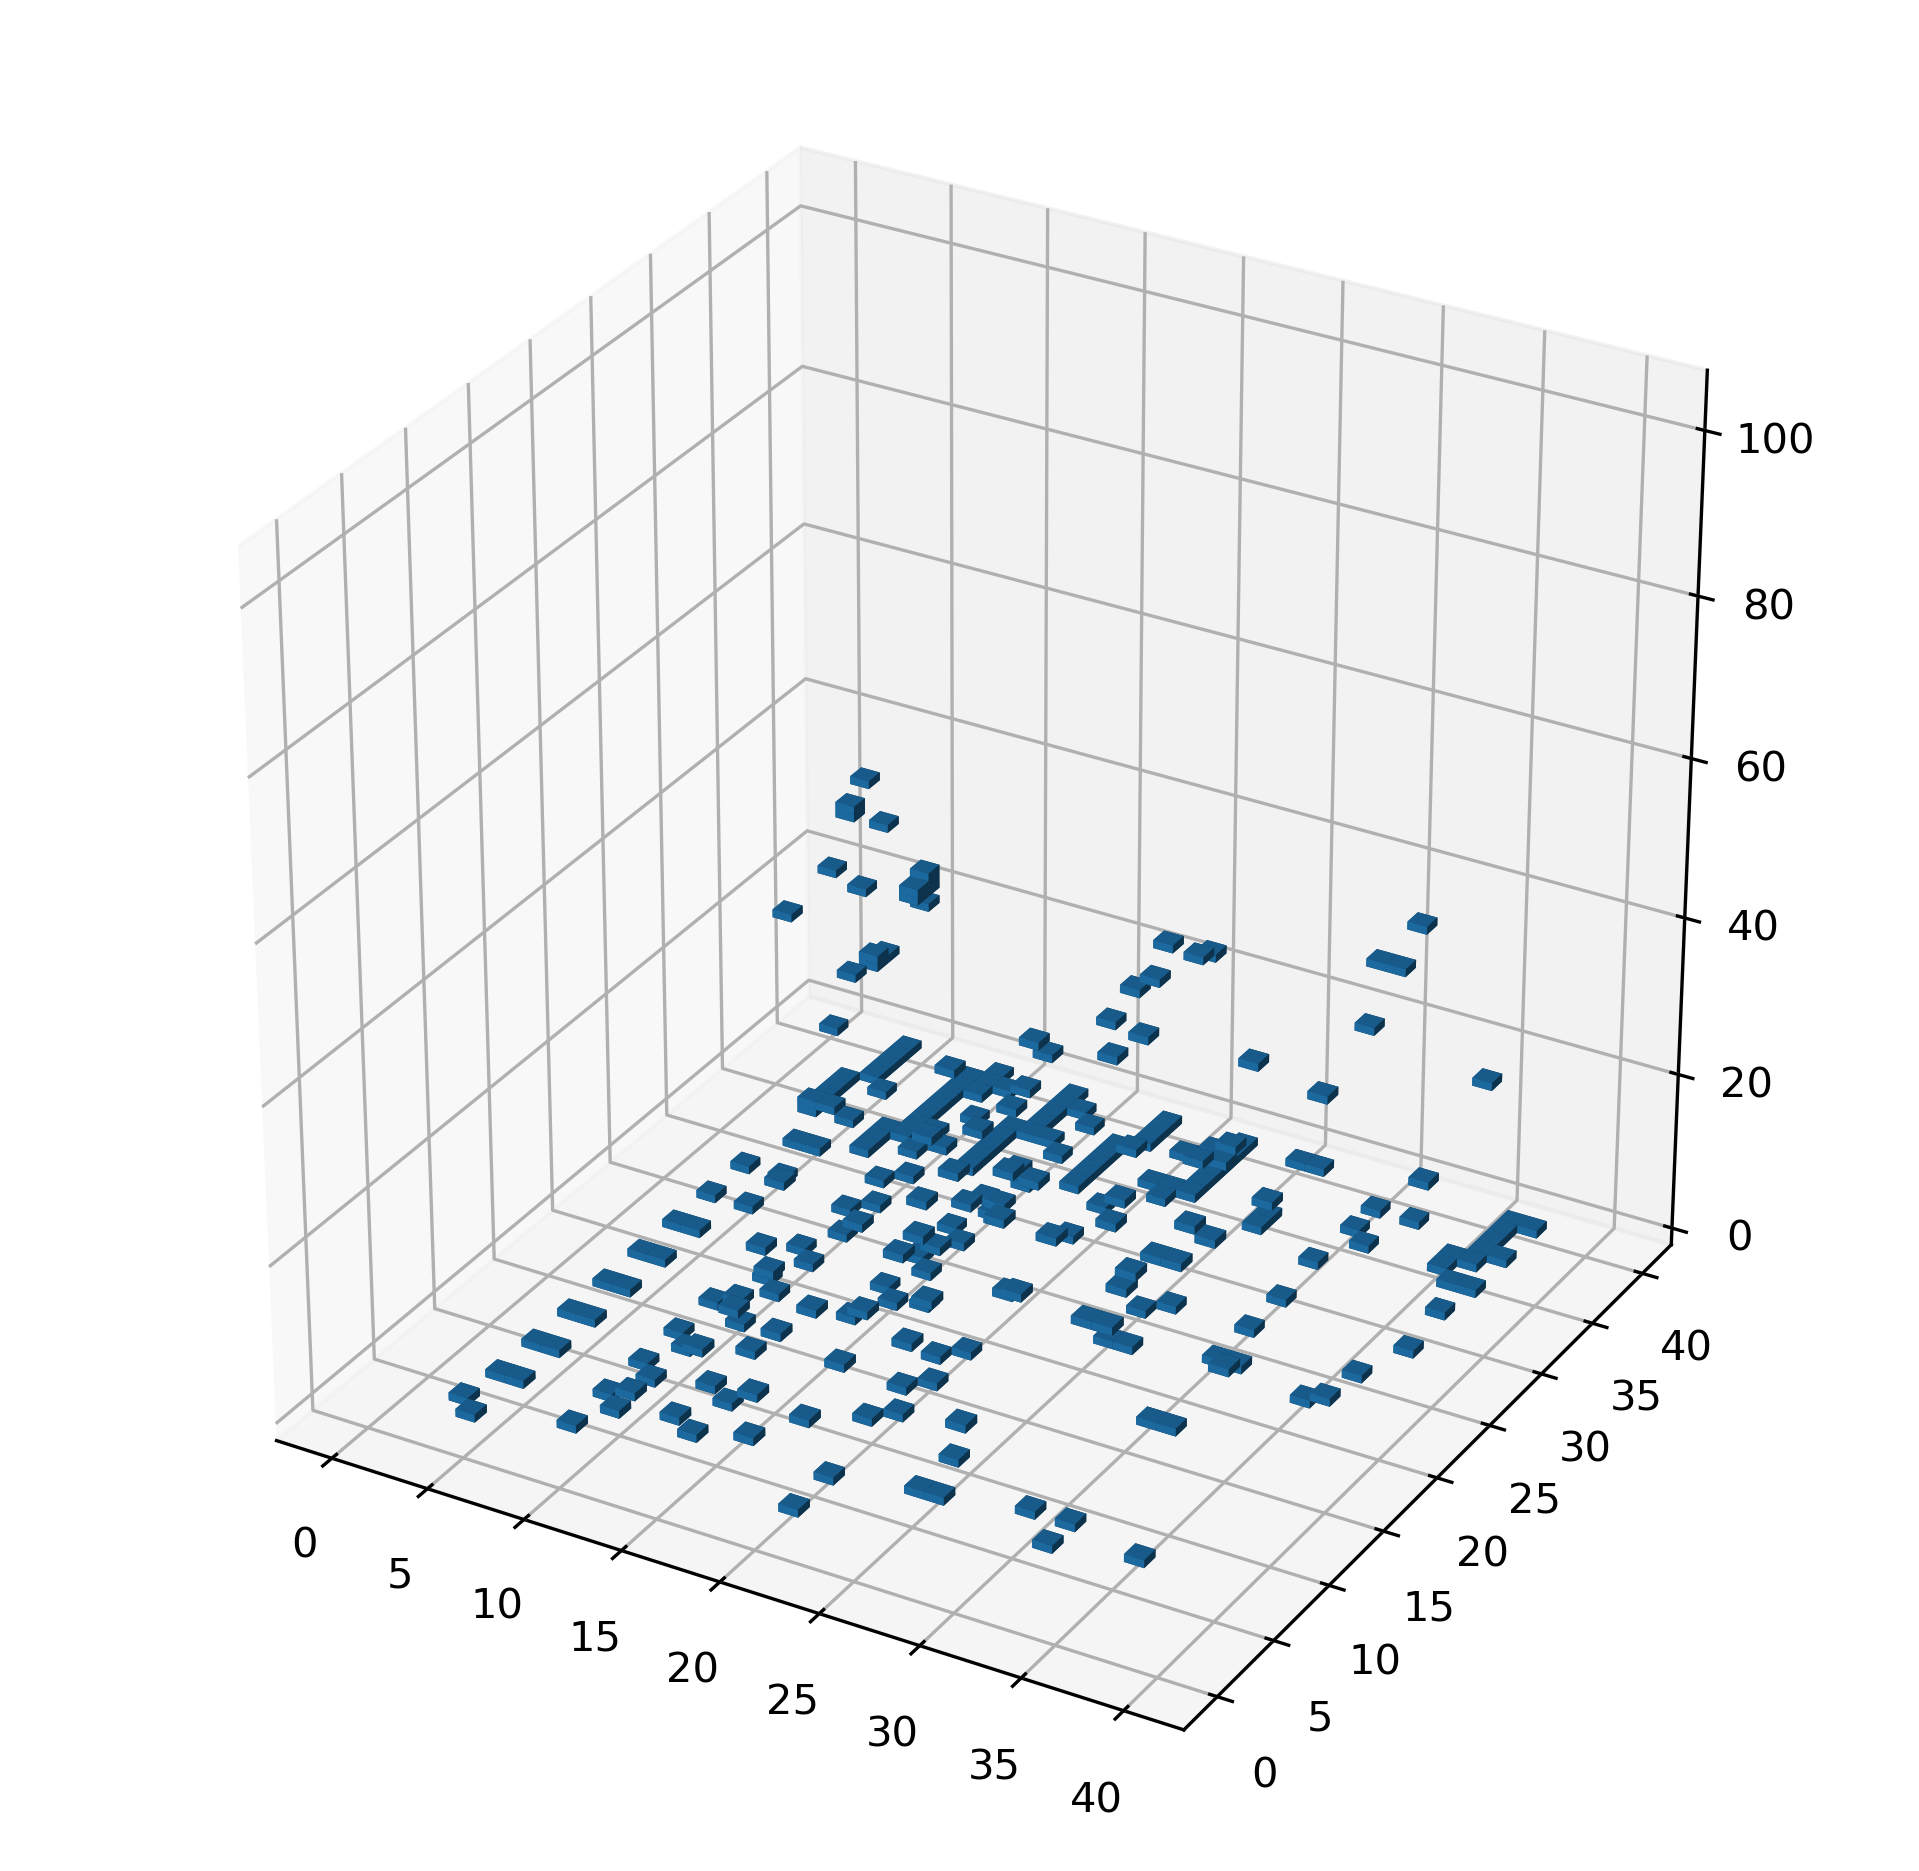

In [ ]:
fig, axs = plt.subplots(figsize=(8,8), dpi=300, subplot_kw={'projection': '3d'})
voxel_im.show(ctx=axs)

In [ ]:
# export

def VoxelBlock(cls=VoxelImage, **kwargs):
    "Block for `VoxelImage`"
    return TransformBlock(partial(cls.create, **kwargs))

In [ ]:
# export

class LasColReader(DisplayedTransform):
    "Modify `ColReader` to return coordinates from dataframe"
    def __init__(self, cols, pref='', suff='.las'):
        store_attr()
        self.pref = str(pref) + os.path.sep if isinstance(pref,Path) else pref
        self.cols = L(cols)
        
    def _do_one(self, r, c):
        "Return fname, plot_x, plot_y -tuple"
        o = r[c] if isinstance(c,int) else r[c] if c=='name' else getattr(r,c)
        if len(self.pref)==0 and len(self.suff)==0: return o
        return [f"{self.pref}{o}{self.suff}", r['x'], r['y']]
    
    def __call__(self, o, **kwargs):
        if len(self.cols) == 1: return self._do_one(o, self.cols[0])
        return L(self._do_one(o,c) for c in self.cols)

In [ ]:
df = pd.DataFrame(columns=['sampleplotid', 'x', 'y', 'v'], data=[[914153, plot_x, plot_y, 123.456]], dtype=object)
df

,sampleplotid,x,y,v
0,914153,365188,6.94385e+06,123.456


In [ ]:
test = DataBlock(blocks=(VoxelBlock, RegressionBlock),
                 get_x=ColReader('sampleplotid', pref='data/', suff='.las'),#LasColReader('sampleplotid', pref='data/', suff='.las'),
                 get_y=ColReader('v'),
                 splitter=None
                )
test

In [ ]:
ds = test.datasets(source=df)
ds

(#1) [(VoxelImage size=1x105x40x40, tensor(123.4560))]

<Axes3DSubplot:>

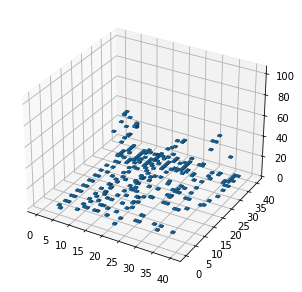

In [ ]:
ds[0][0].show()

In [ ]:
dls = test.dataloaders(source=df, bs=1)

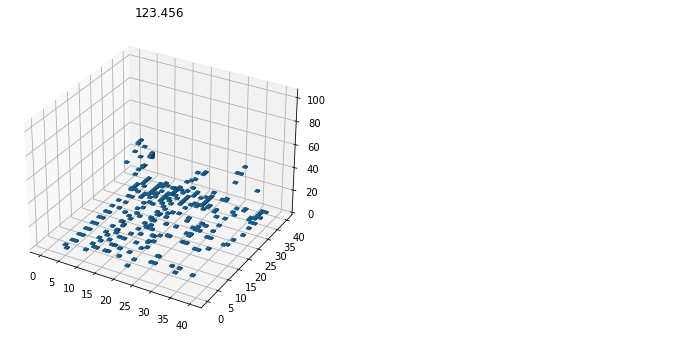

In [ ]:
dls.show_batch()

Dataloaders for `VoxelImage`

In [ ]:
# export

class VoxelDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', bin_voxels:bool=False, max_h:float=42., num_bins:int=40, num_vert_bins:int=105,
                plot_size:float=9., bottom_voxels:bool=False, mask_plot:bool=False, valid_pct=0.2, seed=None, fn_col=0,
                folder=None, suff='.las', label_col=1, label_delim=None, y_block=None, valid_col=None,
                item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and (len_label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        # Todo put block_kwargs to a single argument
        block_kwargs = {'bin_voxels':bin_voxels, 'max_h':max_h, 'num_bins':num_bins, 'num_vert_bins': num_vert_bins,
                        'plot_size':plot_size, 'bottom_voxels':bottom_voxels, 'mask_plot':mask_plot}
        dblock = DataBlock(blocks=(VoxelBlock(**block_kwargs), y_block),
                           #get_items=partial(get_files_from_df, extension='.las', df=df, fn_col=fn_col), 
                           #get_x=partial(get_las_files_and_voxel_kwargs, df=df,
                           #              bottom_voxels=bottom_voxels, mask_plot=mask_plot),
                           #get_y=partial(get_y_las, df=df, col=label_col),
                           #get_x=LasColReader(fn_col, pref=pref, suff='.las'),
                           #get_x= lambda x:([x[fn_col], [x['x'], x['y']]]),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)
    
    @classmethod
    def from_csv(cls, path, csv_fname='labels.csv', header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, **kwargs)
    
VoxelDataLoaders.from_csv = delegates(to=VoxelDataLoaders.from_df)(VoxelDataLoaders.from_csv)

In [ ]:
dls = VoxelDataLoaders.from_df(df, folder='data/', y_block=RegressionBlock, suff='.las',
                               label_col='v', fn_col='sampleplotid', bs=1)

In [ ]:
dls.one_batch()

(VoxelImage size=1x1x105x40x40, tensor([123.4560]))

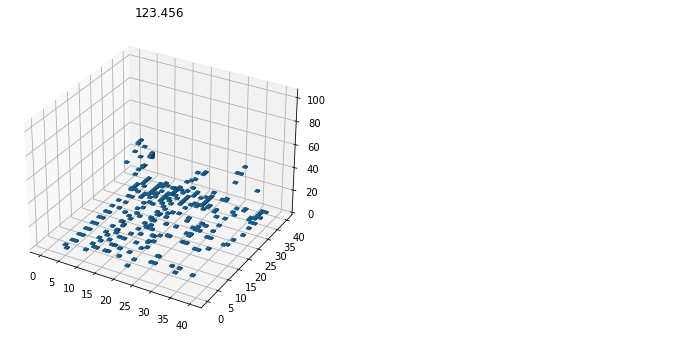

In [ ]:
dls.show_batch()

It's also possible to specify different arguments for `VoxelImage`, like `mask_plot`:

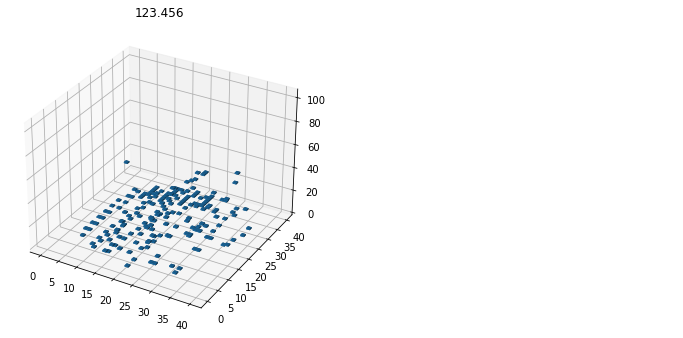

In [ ]:
dls = VoxelDataLoaders.from_df(df, folder='data/', label_col='v', suff='.las',
                               fn_col='sampleplotid', bs=1, y_block=RegressionBlock,
                               mask_plot=True)
dls.show_batch()

Or `bottom_voxels`

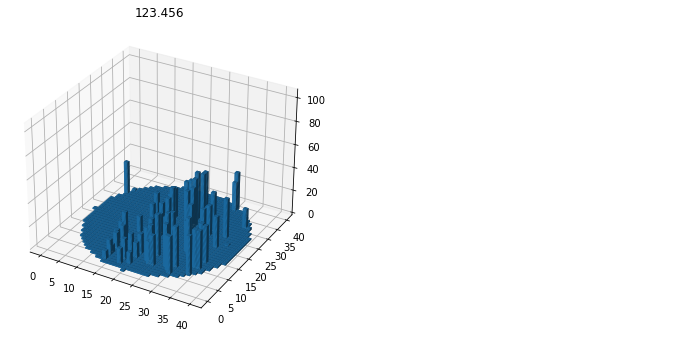

In [ ]:
dls = VoxelDataLoaders.from_df(df, folder='data/', label_col='v', suff='.las',
                               fn_col='sampleplotid', bs=1,y_block=RegressionBlock,
                               mask_plot=True, bottom_voxels=True)
dls.show_batch()

# Tiling larger tiles

For inference, the input data isn't only a single field plot, but several larger las-tiles. End product should be raster with 16x16m pixel resolution.

> Why 16x16m? Because field plots are circles with 9m radius, and 16x16m rectangles have same area than circles with 9m radius.

In [ ]:
# export

def lastile_to_df(fn, res:int=16) -> pd.DataFrame:
    "Tile dataframe, to `res` times `res` cells and process as dataframe."
    tile = laspy.file.File(fn, mode='r')
    xmin = np.floor(tile.x.min())
    xmax = np.ceil(tile.x.max())
    ymin = np.floor(tile.y.min())
    ymax = np.ceil(tile.y.max())
    ncols = int(np.floor((xmax - xmin) / res))
    nrows = int(np.floor((ymax - ymin) / res))
    for col, row in product(range(0, ncols), range(0, nrows)):
        cell_xmin = xmin + col*res
        cell_xmax = cell_xmin + res
        cell_ymin = ymin + row*res
        cell_ymax = cell_ymin + row*res
        celldata_x = np.logical_and((tile.x >= cell_xmin), (tile.x <= cell_xmax))
        celldata_y = np.logical_and((tile.y >= cell_ymin), (tile.y <= cell_ymax))
        cell = tile.points[np.where(np.logical_and(celldata_x, celldata_y))]
        print(cell.x, col, row)

In [ ]:
# hide

from nbdev.export import notebook2script
notebook2script()
!nbdev_build_docs

Converted 00_data.image.ipynb.
Converted 01_data.las.ipynb.
Converted 02_tabular.preprocessing.ipynb.
Converted 03_model.inception3dv3.ipynb.
Converted 04_interpretation.ipynb.
Converted 05_metrics.ipynb.
Converted 06_model.ensemble.ipynb.
Converted 07_model.alexnet.ipynb.
Converted index.ipynb.
converting: /mnt/d/Users/E1005164/enveco/nbs/00_data.image.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/02_tabular.preprocessing.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/01_data.las.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/05_metrics.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/06_model.ensemble.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/04_interpretation.ipynb
converting: /mnt/d/Users/E1005164/enveco/nbs/index.ipynb
converting /mnt/d/Users/E1005164/enveco/nbs/index.ipynb to README.md
